## Pre requirement
Install shapely only when you don't have.

In [3]:

!pip install shapely


# Race Line
## Define parameters

In [9]:
import copy
import os
import numpy as np
from datetime import datetime
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

# Number of times to iterate each new race line point
# keep this at 3-8 for best balance of performance and desired result
XI_ITERATIONS=8 # default 4

# Number of times to scan the entire race track to iterate
# 500 will get a good start, 1500 will be closer to optimal result
LINE_ITERATIONS=100 # default 1000
TRACK_NAME = 'reInvent2019_track'

## Useful functions

In [10]:
def menger_curvature(pt1, pt2, pt3, atol=1e-3):

    vec21 = np.array([pt1[0]-pt2[0], pt1[1]-pt2[1]])
    vec23 = np.array([pt3[0]-pt2[0], pt3[1]-pt2[1]])

    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)

    theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))
    if np.isclose(theta-np.pi, 0.0, atol=atol):
        theta = 0.0

    dist13 = np.linalg.norm(vec21-vec23)

    return 2*np.sin(theta) / dist13

def improve_race_line(old_line, inner_border, outer_border):
    '''Use gradient descent, inspired by K1999, to find the racing line'''
    # start with the center line
    new_line = copy.deepcopy(old_line)
    ls_inner_border = Polygon(inner_border)
    ls_outer_border = Polygon(outer_border)
    for i in range(0,len(new_line)):
        xi = new_line[i]
        npoints = len(new_line)
        prevprev = (i - 2 + npoints) % npoints
        prev = (i - 1 + npoints) % npoints
        nexxt = (i + 1 + npoints) % npoints
        nexxtnexxt = (i + 2 + npoints) % npoints
        #print("%d: %d %d %d %d %d" % (npoints, prevprev, prev, i, nexxt, nexxtnexxt))
        ci = menger_curvature(new_line[prev], xi, new_line[nexxt])
        c1 = menger_curvature(new_line[prevprev], new_line[prev], xi)
        c2 = menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])
        target_ci = (c1 + c2) / 2
        #@if target_ci > 1.1:
        #    target_ci=1.1
        #    print("i %d ci %f target_ci %f c1 %f c2 %f" % (i, ci, target_ci, c1, c2))

        # Calculate prospective new track position, start at half-way (curvature zero)
        xi_bound1 = copy.deepcopy(xi)
        xi_bound2 = ((new_line[nexxt][0] + new_line[prev][0]) / 2.0, (new_line[nexxt][1] + new_line[prev][1]) / 2.0)
        p_xi = copy.deepcopy(xi)
        for j in range(0,XI_ITERATIONS):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])
            #print("i: {} iter {} p_ci {} p_xi {} b1 {} b2 {}".format(i,j,p_ci,p_xi,xi_bound1, xi_bound2))
            if np.isclose(p_ci, target_ci):
                break
            if p_ci < target_ci:
                # too flat, shrinking track too much
                #print("too flat")
            
                xi_bound2 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound1[0] + p_xi[0]) / 2.0, (xi_bound1[1] + p_xi[1]) / 2.0)
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound1 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
            else:
                #print("too curved")
                # too curved, flatten it out
                xi_bound1 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound2[0] + p_xi[0]) / 2.0, (xi_bound2[1] + p_xi[1]) / 2.0)

                # If iteration pushes the point beyond the border of the track,
                # just abandon the refinement at this point.  As adjacent
                # points are adjusted within the track the point should gradually
                # make its way to a new position.  A better way would be to use
                # a projection of the point on the border as the new bound.  Later.
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound2 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
        new_xi = p_xi
        # New point which has mid-curvature of prev and next points but may be outside of track
        #print((new_line[i], new_xi))
        new_line[i] = new_xi
    return new_line

def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        ax.annotate(i, (p[0], p[1]))

## Main 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in arccos


Writing python code to ./reInvent2019_track-100-8-2021-06-20-062652.py
Writing numpy binary to ./reInvent2019_track-100-8-2021-06-20-062652.npy


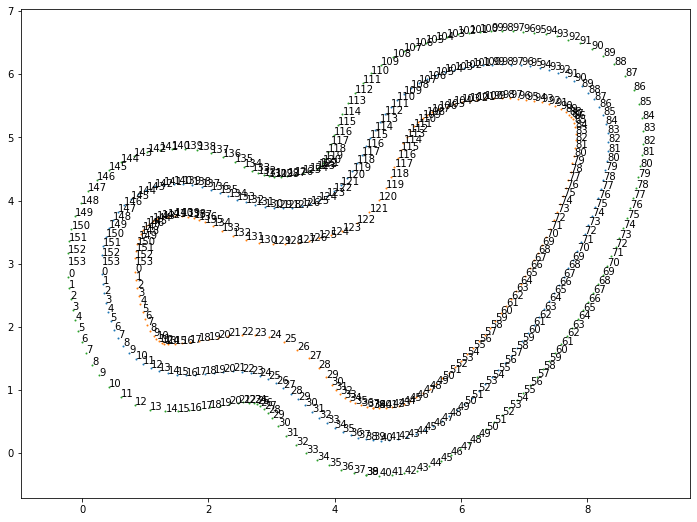

<Figure size 432x288 with 0 Axes>

In [11]:
os.system("wget 'https://github.com/aws-deepracer-community/deepracer-race-data/raw/main/raw_data/tracks/npy/%s.npy' -O %s.npy" % (TRACK_NAME ,TRACK_NAME))
waypoints = np.load("%s.npy" % TRACK_NAME)
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

race_line = copy.deepcopy(center_line[:-1])
for i in range(LINE_ITERATIONS):
    race_line = improve_race_line(race_line, inner_border, outer_border)  # Remove "_new" for entire track width
    if i % 20 == 0: print("Iteration %d" % i, end="\r")

now = datetime.now()
prefix = './%s-%d-%d-%s' % (TRACK_NAME, LINE_ITERATIONS, XI_ITERATIONS, now.strftime('%Y-%m-%d-%H%M%S'))
py_fname = prefix + '.py'
npy_fname = prefix + '.npy'
with open(py_fname, "w+") as file:
    print("Writing python code to %s" % py_fname)
    file.write(np.array_repr(race_line))
    
print("Writing numpy binary to %s" % npy_fname)
np.save(npy_fname, race_line)

# Plot 
fig, ax = plt.subplots(figsize=(12,9))
plot_points(ax, race_line)
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()
plt.savefig('%s.png' %TRACK_NAME)

# Speed Map

In [26]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np


# Change manually (this is only so that output files are named correctly)
#fpath = "./reInvent2019_track-10000-8-2021-04-22-223450.npy"
#fpath = "./reInvent2019_track-100-8-2021-06-20-062652.npy"
fpath = npy_fname
TRACK_NAME = "reInvent2019_track"
LOOK_AHEAD_POINTS = 1
MIN_SPEED = 1.33
MAX_SPEED = 4

In [27]:
def circle_radius(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    # In case a is zero (so radius is infinity)
    try:
        r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    except:
        r = 999

    return r


def circle_indexes(mylist, index_car, add_index_1=0, add_index_2=0):

    list_len = len(mylist)

    # if index >= list_len:
    #     raise ValueError("Index out of range in circle_indexes()")

    # Use modulo to consider that track is cyclical
    index_1 = (index_car + add_index_1) % list_len
    index_2 = (index_car + add_index_2) % list_len

    return [index_car, index_1, index_2]

def optimal_velocity(track, min_speed, max_speed, look_ahead_points):

    # Calculate the radius for every point of the track
    radius = []
    for i in range(len(track)):
        indexes = circle_indexes(track, i, add_index_1=-1, add_index_2=1)
        coords = [track[indexes[0]],
                  track[indexes[1]], track[indexes[2]]]
        radius.append(circle_radius(coords))

    # Get the max_velocity for the smallest radius
    # That value should multiplied by a constant multiple
    v_min_r = min(radius)**0.5
    constant_multiple = min_speed / v_min_r
    #print(f"Constant multiple for optimal speed: {constant_multiple}")

    if look_ahead_points == 0:
        # Get the maximal velocity from radius
        max_velocity = [(constant_multiple * i**0.5) for i in radius]
        # Get velocity from max_velocity (cap at MAX_SPEED)
        velocity = [min(v, max_speed) for v in max_velocity]
        return velocity

    else:
        # Looks at the next n radii of points and takes the minimum
        # goal: reduce lookahead until car crashes bc no time to break
        LOOK_AHEAD_POINTS = look_ahead_points
        radius_lookahead = []
        for i in range(len(radius)):
            next_n_radius = []
            for j in range(LOOK_AHEAD_POINTS+1):
                index = circle_indexes(
                    mylist=radius, index_car=i, add_index_1=j)[1]
                next_n_radius.append(radius[index])
            radius_lookahead.append(min(next_n_radius))
        max_velocity_lookahead = [(constant_multiple * i**0.5)
                                  for i in radius_lookahead]
        velocity_lookahead = [min(v, max_speed)
                              for v in max_velocity_lookahead]
        return velocity_lookahead


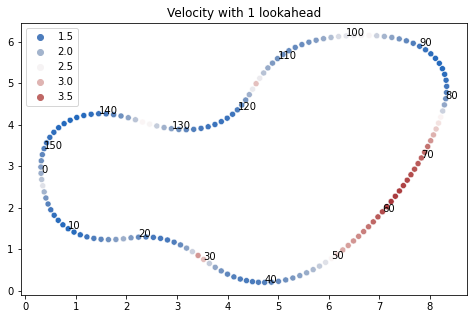

<Figure size 432x288 with 0 Axes>

In [28]:
racing_track = np.load(fpath)
x = [i[0] for i in racing_track]
y = [i[1] for i in racing_track]

# Without lookahead
velocity_no_lookahead = optimal_velocity(track=racing_track,
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=LOOK_AHEAD_POINTS)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity_no_lookahead,
                     palette="vlag").set_title("Velocity with %s lookahead" %LOOK_AHEAD_POINTS)
#for i in racing_track:
#    ax.annotate(i, (x[i], y[i]))
ii=0
for i in racing_track:
    if ii%10==0:
        plt.text(i[0], i[1], ii)
    ii=ii+1
plt.show()
plt.savefig('%s-speedMap.png' %TRACK_NAME)

# Race Line and Speed python code

In [35]:
racing_track_everything = []
for i in range(len(racing_track)):
    racing_track_everything.append([racing_track[i][0],
                                    racing_track[i][1],
                                    velocity_no_lookahead[i]])
# Round to 5 decimals
racing_track_everything = np.around(racing_track_everything, 5).tolist()

print(racing_track_everything)


[[0.31104, 2.83077, 1.94357], [0.32414, 2.68038, 2.12813], [0.34543, 2.53082, 2.36228], [0.3733, 2.38233, 2.00229], [0.4071, 2.23508, 1.72364], [0.44978, 2.09051, 1.55854], [0.50383, 1.95098, 1.45322], [0.57068, 1.81924, 1.3823], [0.65072, 1.69787, 1.35427], [0.74357, 1.58903, 1.34103], [0.84808, 1.49401, 1.34103], [0.96297, 1.4137, 1.35405], [1.0868, 1.34841, 1.38287], [1.21814, 1.29817, 1.43986], [1.35553, 1.2625, 1.50596], [1.49767, 1.24086, 1.58553], [1.64334, 1.23254, 1.69214], [1.79132, 1.23651, 1.8091], [1.94049, 1.25165, 1.9574], [2.08953, 1.27651, 1.76552], [2.23853, 1.29226, 1.61025], [2.38633, 1.29631, 1.51251], [2.53169, 1.28683, 1.47229], [2.67336, 1.26274, 1.47229], [2.81028, 1.22393, 1.47402], [2.94174, 1.17098, 1.52205], [3.06743, 1.10507, 1.63422], [3.18761, 1.02804, 1.84269], [3.3031, 0.94225, 2.23531], [3.4152, 0.85046, 3.1885], [3.52557, 0.7557, 2.94368], [3.63872, 0.65878, 2.18937], [3.75415, 0.56537, 1.88155], [3.87338, 0.47846, 1.69813], [3.99682, 0.40069, 1.5958

In [36]:
# Write to py file
with open(f'optimals_newest_{TRACK_NAME}.py', 'w') as f:
    f.write("[")
    for line in racing_track_everything:
        f.write("%s" % line)
        if line != racing_track_everything[-1]:
            f.write(",\n")
    f.write("]")

# High torlance race line

In [39]:

def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

def x_perc_width(waypoint, perc_width):
    
    center_x, center_y, inner_x, inner_y, outer_x, outer_y = waypoint
    
    width = dist_2_points(inner_x, outer_x, inner_y, outer_y)
    
    delta_x = outer_x-inner_x
    delta_y = outer_y-inner_y
    
    inner_x_new = inner_x + delta_x/2 * (1-perc_width)
    outer_x_new = outer_x - delta_x/2 * (1-perc_width)
    inner_y_new = inner_y + delta_y/2 * (1-perc_width)
    outer_y_new = outer_y - delta_y/2 * (1-perc_width)
    
    return [center_x, center_y, inner_x_new, inner_y_new, outer_x_new, outer_y_new]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in arccos


Writing python code to ./reInvent2019_track-10000-8-2021-06-22-160251PERC_WIDTH.py
Writing numpy binary to ./reInvent2019_track-10000-8-2021-06-22-160251PERC_WIDTH.npy


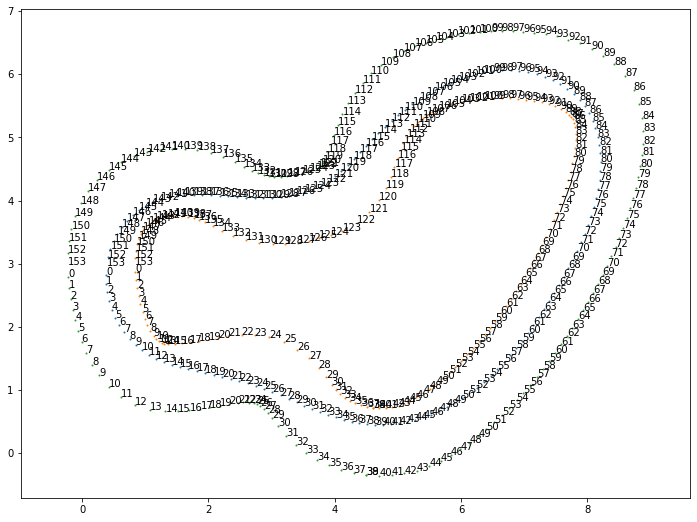

<Figure size 432x288 with 0 Axes>

In [ ]:

PERC_WIDTH = 0.5
LINE_ITERATIONS = 10000


os.system("wget 'https://github.com/aws-deepracer-community/deepracer-race-data/raw/main/raw_data/tracks/npy/%s.npy' -O %s.npy" % (TRACK_NAME ,TRACK_NAME))

waypoints = np.load("%s.npy" % TRACK_NAME)
waypoints_new = [x_perc_width(waypoint, perc_width=PERC_WIDTH) for waypoint in waypoints]
waypoints_new = np.asarray(waypoints_new)

center_line = waypoints[:,0:2]
inner_border = waypoints_new[:,2:4]
outer_border = waypoints_new[:,4:6]

race_line = copy.deepcopy(center_line[:-1])
for i in range(LINE_ITERATIONS):
    race_line = improve_race_line(race_line, inner_border, outer_border)  # Remove "_new" for entire track width
    if i % 20 == 0: print("Iteration %d" % i, end="\r")

now = datetime.now()
prefix = './%s-%d-%d-%s' % (TRACK_NAME, LINE_ITERATIONS, XI_ITERATIONS, now.strftime('%Y-%m-%d-%H%M%S'))
py_fname = prefix + '_PERC_WIDTH.py'
npy_fname = prefix + '_PERC_WIDTH.npy'
with open(py_fname, "w+") as file:
    print("Writing python code to %s" % py_fname)
    file.write(np.array_repr(race_line))
    
print("Writing numpy binary to %s" % npy_fname)
np.save(npy_fname, race_line)

# Plot 
fig, ax = plt.subplots(figsize=(12,9))
plot_points(ax, race_line)
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()
plt.savefig('%s_PERC_WIDTH.png' %TRACK_NAME)
